In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
import nltk

warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNHD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

bulk_project = "240826_BSimons"
sc_project = "240805_BSimons"
PROJECTS = f"{bulk_project}_{sc_project}"

path_to_01_output = f"{outdir}/tree_analysis/{bulk_project}/01_output"
path_to_06_output = f"{outdir}/tree_analysis/06_output/{PROJECTS}"
os.system(f"mkdir -p {path_to_06_output}")

with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)

mouseid = "m1"

bulk_metadata = pd.read_excel("/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/240826_BSimons/240829 sample sheet.xlsx")
bulk_metadata.columns = ["MID", "mouseID", "organ", "population"]

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
maindf = maindf[maindf["mouseID"] == mouseid]

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85
clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]

sc_clonedf = clonedf[clonedf['dataset.name'] == sc_project][["barcode", "id", 'V.gene', 'J.gene', 'D.gene', "aaSeqCDR3", "nSeqCDR3"]].reset_index().drop("index", axis = 1)

# path_to_clonesets = f"{outdir}/VDJ_output/03_output/FASTA_output/{bulk_project}/VDJ_output_{thres}/{mouseid}/all/clonesets.csv"
# bulk_clonedf = pd.read_csv(path_to_clonesets)[["id", 'V.gene', 'J.gene', 'D.gene', f'VJcombi_CDR3_{thres}', "aaSeqCDR3", "nSeqCDR3"]]
# bulk_clonedf.columns = ["id", 'V.gene', 'J.gene', 'D.gene', "cloneid", "aaSeqCDR3", "nSeqCDR3"]
# bulk_clonedf["mouseID"] = bulk_clonedf["id"].apply(lambda x: bulk_metadata[bulk_metadata["MID"] == x]["mouseID"].values[0])
# bulk_clonedf = bulk_clonedf[bulk_clonedf["mouseID"] == mouseid]

sc_clonedf["mouseID"] = sc_clonedf["id"].apply(lambda x: "m" + x.replace("M", "").replace("P", ""))
sc_clonedf = sc_clonedf[sc_clonedf["mouseID"] == mouseid]


/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
color_path = f"{bulk_project}_color.csv"
tree_dist_seqdf = pd.DataFrame()

for cloneid in tqdm(maindf.cloneid.unique()):
    V_gene = cloneid.split("_")[1]
    J_gene = cloneid.split("_")[2]
    cdr3_len = cloneid.split("_")[3]
    mouseid = cloneid.split("_")[0]

    treeobj = saveTreeobj[cloneid]
    seqdf = treeobj.seqdf.copy()
    idmapdf = treeobj.idmapseqdf.copy()
    bulkdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
    bulkdf["aaSeqCDR3"] = bulkdf["ID"].apply(lambda x: x.split("|")[2].split(":")[1])

    scdf = sc_clonedf[(sc_clonedf["V.gene"] == V_gene.split("-0")[0]) & 
                    (sc_clonedf["J.gene"] == J_gene.split("-0")[0])]

    scdf["len"] = scdf["nSeqCDR3"].apply(lambda x: len(x))
    scdf = scdf[scdf["len"] == int(cdr3_len)]

    if scdf.shape[0] > 0:
        for i in range(0, scdf.shape[0]):
            barcode = scdf.iloc[i].barcode
            sampleid = scdf.iloc[i].id
            sc_seq = scdf[(scdf["barcode"] == barcode) & (scdf["id"] == sampleid)]["aaSeqCDR3"].values[0] 

            bulkdf[f"{sampleid}_{barcode}"] = bulkdf["aaSeqCDR3"].apply(lambda x: nltk.edit_distance(x, sc_seq)/len(x))
        bulkdf["min_dist_to_a_cell"] = bulkdf[[item for item in bulkdf.columns if sampleid in item]].apply(lambda x: min(x), axis = 1)

        bulkdf = bulkdf[["ID", "seq", "abundance", "MID", "seqid", "min_dist_to_a_cell"]]
        bulkdf["cloneid"] = cloneid
        tree_dist_seqdf = pd.concat([tree_dist_seqdf, bulkdf], axis = 0)

100%|██████████| 396/396 [00:07<00:00, 56.05it/s]


In [9]:
tree_dist_seqdf

,ID,seq,abundance,MID,seqid,min_dist_to_a_cell,cloneid
0,Sample:MID1|Mouse:m1|CDR3aa:CTRSPYYGNSYGYFDVW|...,CAGGTCCAGCTGAAGCAGTCTGGGGCTGAGCTGGTGAGGCCTGGGG...,8,MID1,seq1,0.352941,m1_IGHV1-76-01_IGHJ1-01_51_1
1,Sample:MID1|Mouse:m1|CDR3aa:CARSPYYGSTYGYFDVW|...,CAGGTCCAGCTGAAGCAGTCTGGGGCTGAGCTGGTGAGGCCTGGGG...,7,MID1,seq1,0.294118,m1_IGHV1-76-01_IGHJ1-01_51_1
2,Sample:MID1|Mouse:m1|CDR3aa:CTRSPYYGNSYGYFDVW|...,CAGGTCCAGCTGAAGCAGTCTGGGCCTGAACTGGTGAGGCCTGGGA...,1,MID1,seq2,0.352941,m1_IGHV1-76-01_IGHJ1-01_51_1
3,Sample:MID2|Mouse:m1|CDR3aa:CTRSPYYGNSYGYFDVW|...,CAGGTCCAGCTGAAGCAGTCTGGGCCTGAACTGGTGAGGCCTGGGA...,9,MID2,seq3,0.352941,m1_IGHV1-76-01_IGHJ1-01_51_1
4,Sample:MID2|Mouse:m1|CDR3aa:CSRSPYYGNSYGYFDVW|...,CAGGTCCAGCTGAAGCAGTCTGGGCCTGAACTGGTGAGGCCTGGGA...,7,MID2,seq2,0.352941,m1_IGHV1-76-01_IGHJ1-01_51_1
...,...,...,...,...,...,...,...
0,Sample:MID3|Mouse:m1|CDR3aa:CVRRGHSNYVPFGVW|CD...,CAGGTCCAACTGCAGCAGCCTGGGACTGAACTGGTGAAGCCTGGGG...,5,MID3,seq1,0.533333,m1_IGHV1-53-01_IGHJ1-03_45_3
1,Sample:MID3|Mouse:m1|CDR3aa:CVRRGHSNYVPFDVW|CD...,CAGGTCCAACTGCAGCAGCCTGGGACTGAACTGGTGAAGCCTGGGG...,4,MID3,seq2,0.466667,m1_IGHV1-53-01_IGHJ1-03_45_3
0,Sample:MID2|Mouse:m1|CDR3aa:CAGGNPYYFDYW|CDR3n...,CAGGTTCAGCTGCAGCAGTCTGGAGCTGAGCTGATGAAGCCTGGGG...,61,MID2,seq1,0.583333,m1_IGHV1-9-01_IGHJ2-01_36_1
1,Sample:MID2|Mouse:m1|CDR3aa:CAGGNPYYFDYW|CDR3n...,CAGGTTCAGCTGCAGCAGTCTGGAGCTGAGCTGATGAAGCCTGGGG...,1,MID2,seq2,0.583333,m1_IGHV1-9-01_IGHJ2-01_36_1


In [4]:
tree_dist_seqdf[tree_dist_seqdf["min_dist_to_a_cell"] == min(tree_dist_seqdf["min_dist_to_a_cell"])].cloneid.unique()

array(['m1_IGHV1-47-01_IGHJ3-01_39_1', 'm1_IGHV1-72-01_IGHJ4-01_45_1',
       'm1_IGHV1-78-01_IGHJ2-01_48_1', 'm1_IGHV1-74-01_IGHJ3-01_39_1',
       'm1_IGHV1-39-01_IGHJ3-01_36_1', 'm1_IGHV8-12-01_IGHJ1-03_57_1',
       'm1_IGHV8-8-01_IGHJ4-01_51_2', 'm1_IGHV13-2-01_IGHJ3-01_42_1',
       'm1_IGHV8-5-01_IGHJ2-01_51_1', 'm1_IGHV1-22-01_IGHJ1-01_48_1',
       'm1_IGHV1-26-01_IGHJ2-01_30_1', 'm1_IGHV1-26-01_IGHJ2-01_33_3',
       'm1_IGHV5-4-01_IGHJ3-01_30_1', 'm1_IGHV1-77-01_IGHJ3-01_39_1',
       'm1_IGHV1-76-01_IGHJ4-01_42_1', 'm1_IGHV1-72-01_IGHJ4-01_51_1',
       'm1_IGHV8-12-01_IGHJ1-03_42_2', 'm1_IGHV1-58-01_IGHJ2-01_39_1',
       'm1_IGHV1-76-01_IGHJ1-03_48_1', 'm1_IGHV1-26-01_IGHJ2-01_42_4',
       'm1_IGHV1-80-01_IGHJ4-01_39_3', 'm1_IGHV14-4-01_IGHJ2-02_33_1',
       'm1_IGHV1-72-01_IGHJ2-01_39_1', 'm1_IGHV1-82-01_IGHJ4-01_30_1',
       'm1_IGHV1-52-01_IGHJ4-01_36_1', 'm1_IGHV4-1-01_IGHJ4-01_45_1',
       'm1_IGHV1-26-01_IGHJ2-01_36_3', 'm1_IGHV1-75-01_IGHJ4-01_39_1',
       'm1

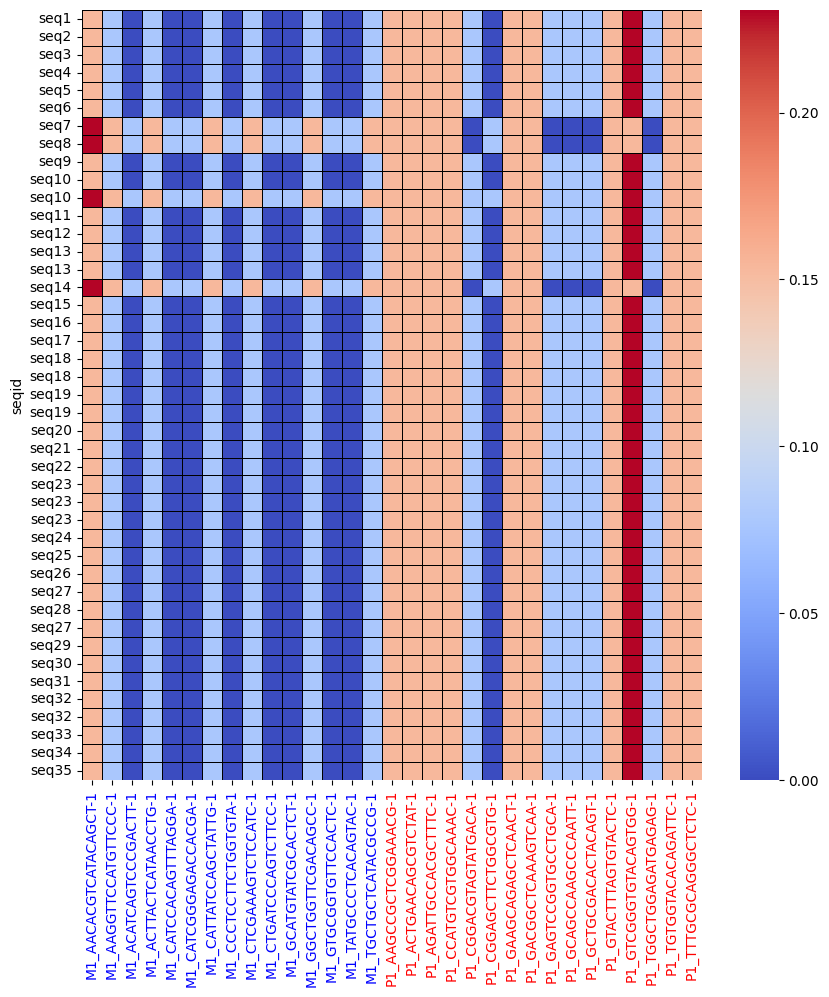

In [5]:
# cloneid = "m1_IGHV1-47-01_IGHJ3-01_39_1"
cloneid = "m1_IGHV1-47-01_IGHJ3-01_39_1"

V_gene = cloneid.split("_")[1]
J_gene = cloneid.split("_")[2]
cdr3_len = cloneid.split("_")[3]
mouseid = cloneid.split("_")[0]

treeobj = saveTreeobj[cloneid]
seqdf = treeobj.seqdf.copy()
idmapdf = treeobj.idmapseqdf.copy()
bulkdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
bulkdf["aaSeqCDR3"] = bulkdf["ID"].apply(lambda x: x.split("|")[2].split(":")[1])

scdf = sc_clonedf[(sc_clonedf["V.gene"] == V_gene.split("-0")[0]) & 
                (sc_clonedf["J.gene"] == J_gene.split("-0")[0])]

scdf["len"] = scdf["nSeqCDR3"].apply(lambda x: len(x))
scdf = scdf[scdf["len"] == int(cdr3_len)]

if scdf.shape[0] > 0:
    for i in range(0, scdf.shape[0]):
        barcode = scdf.iloc[i].barcode
        sampleid = scdf.iloc[i].id
        sc_seq = scdf[(scdf["barcode"] == barcode) & (scdf["id"] == sampleid)]["aaSeqCDR3"].values[0] 

        bulkdf[f"{sampleid}_{barcode}"] = bulkdf["aaSeqCDR3"].apply(lambda x: nltk.edit_distance(x, sc_seq)/len(x))
    bulkdf["min_dist_to_a_cell"] = bulkdf[[item for item in bulkdf.columns if sampleid in item]].apply(lambda x: min(x), axis = 1)

# ts = treeobj.generate_tree_style_with_dist(
#     bulkdf = bulkdf,
#     hex_min = "0d0887",
#     hex_max = "f89540",
#     dist_to_cell = "M1_AACACGTCATACAGCT-1")
# treeobj.tree.render(f"%%inline", tree_style = ts)
# plt.show()

plt.figure(figsize= (10, 10))
sns.heatmap(bulkdf[["seqid"] + [item for item in bulkdf.columns if "_" in item and item != "min_dist_to_a_cell"]].set_index("seqid"),
            cmap="coolwarm", cbar=-1, linewidths=0.5, linecolor='black')
for tick_label in plt.gca().get_xticklabels():
    tick_text = tick_label.get_text()
    if "M" in tick_text:
        tick_label.set_color('blue')
    elif "P" in tick_text:
        tick_label.set_color('red')
plt.show()

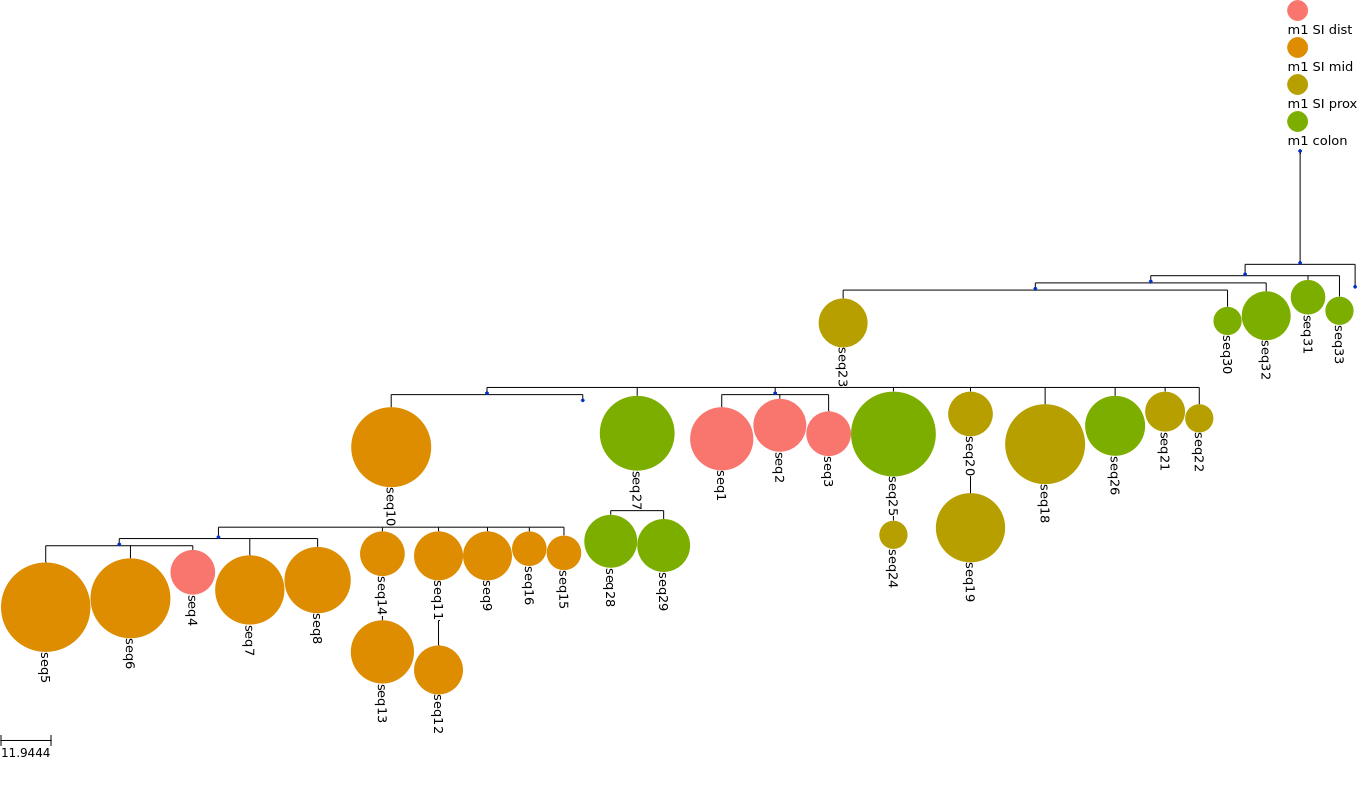

In [6]:
treeobj = saveTreeobj[cloneid] 
avai_mids = treeobj.seqdf["MID"].unique()
mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

ts = treeobj.generate_tree_style(color_path = color_path)

for input_mid in avai_mids:
    if input_mid == "GL":
        input_mid_col = "gray"
    else:
        input_mid_col = mid_color_pal[input_mid]
    ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
    ts.legend.add_face(TextFace(bulk_metadata[bulk_metadata["MID"]==input_mid]["population"].values[0]), column = 0)

treeobj.tree.render("%%inline", tree_style=ts)

In [11]:
display(bulkdf.head())

,ID,seq,abundance,MID,seqid,aaSeqCDR3,M1_AACACGTCATACAGCT-1,M1_AAGGTTCCATGTTCCC-1,M1_ACATCAGTCCCGACTT-1,M1_ACTTACTCATAACCTG-1,...,P1_GACGGCTCAAAGTCAA-1,P1_GAGTCCGGTGCCTGCA-1,P1_GCAGCCAAGCCCAATT-1,P1_GCTGCGACACTACAGT-1,P1_GTACTTTAGTGTACTC-1,P1_GTCGGGTGTACAGTGG-1,P1_TGGCTGGAGATGAGAG-1,P1_TGTGGTACACAGATTC-1,P1_TTTGCGCAGGGCTCTC-1,min_dist_to_a_cell
0,Sample:MID1|Mouse:m1|CDR3aa:CARRSNLGWFAYW|CDR3...,CAGGTTCAGCTGCAGCAGTCTGGGGCTGAGTTAGTGAAGCCTGGAG...,10,MID1,seq1,CARRSNLGWFAYW,0.153846,0.076923,0.0,0.076923,...,0.153846,0.076923,0.076923,0.076923,0.153846,0.230769,0.076923,0.153846,0.153846,0.0
1,Sample:MID1|Mouse:m1|CDR3aa:CARRSNLGWFAYW|CDR3...,CAGGTTCAGCTGCAGCAGTCTGGGGCTGAGTTAGTGAAGCCTGGAG...,7,MID1,seq2,CARRSNLGWFAYW,0.153846,0.076923,0.0,0.076923,...,0.153846,0.076923,0.076923,0.076923,0.153846,0.230769,0.076923,0.153846,0.153846,0.0
2,Sample:MID1|Mouse:m1|CDR3aa:CARRSNLGWFAYW|CDR3...,CAGGTTCAGCTACAGCAGTCTGGGGCTGAGTTAGTGAAGCCTGGAG...,5,MID1,seq3,CARRSNLGWFAYW,0.153846,0.076923,0.0,0.076923,...,0.153846,0.076923,0.076923,0.076923,0.153846,0.230769,0.076923,0.153846,0.153846,0.0
3,Sample:MID1|Mouse:m1|CDR3aa:CARRSNLGWFAYW|CDR3...,CAGGTTCAGCTGCAGCAGTCTGGGGCTGAGTTAGTGAAGCCTGGAG...,5,MID1,seq4,CARRSNLGWFAYW,0.153846,0.076923,0.0,0.076923,...,0.153846,0.076923,0.076923,0.076923,0.153846,0.230769,0.076923,0.153846,0.153846,0.0
4,Sample:MID2|Mouse:m1|CDR3aa:CARRSNLGWFAYW|CDR3...,CAGGTTCAGCTGCAGCAGTCTGGGGCTGAGTTAGTGAAGCCTGGAG...,20,MID2,seq5,CARRSNLGWFAYW,0.153846,0.076923,0.0,0.076923,...,0.153846,0.076923,0.076923,0.076923,0.153846,0.230769,0.076923,0.153846,0.153846,0.0


In [13]:
maindf[maindf["check_QC_tree"] == "pass"].shape

(393, 18)

In [14]:
len(tree_dist_seqdf.cloneid.unique())

300